## Imports

In [3]:
import scipy.io, random
import numpy as np
from utils import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from scipy import stats

## Utils

In [4]:
def plot_forecast(source, prediction, nrow=5, ncol=5, from_=2800, to_=None, figsize=(10,8)):
    n = source.shape[0]
    idx = list(range(n))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
    if to_ is None:
        to_ = source.shape[1]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].plot(range(from_, to_), source[idx[i], from_:to_], c='b', label='Real values')
            axs[r,c].plot(range(from_, to_), prediction[idx[i], from_:to_], c='r', label='Forecasts')
            axs[r,c].grid()
            i += 1
            
    fig.tight_layout()
    handles, labels = fig.axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=2, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))
    plt.setp(axs[-1, :], xlabel='Time')
    plt.show()

In [5]:
def read_data_from_csv(data_path):
    df = pd.read_csv(data_path)
    X = df.iloc[:, 1:].to_numpy()
    return X

In [6]:
def plot_sf(d, F, F_hat, nrow=5, ncol=5, to_=None, figsize=(10,8), step=10):
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize, sharex=True)
    if to_ is None:
        to_ = F.shape[0]
    i = 0
    for r in range(nrow):
        for c in range(ncol):
            axs[r,c].scatter(d[:to_], F[i, :to_,], c='b', label='Actual SF')
            axs[r,c].scatter(d[:to_], F_hat[i, :to_,], c='r', label='Estimated SF')
            axs[r,c].title.set_text(f'Time = {i *step}')
            axs[r,c].grid()
            i += 1
            
    fig.tight_layout()
#     handles, labels = fig.axes[0].get_legend_handles_labels()
#     fig.legend(handles, labels, ncol=2, fontsize='large', loc='upper center', bbox_to_anchor=(0.25, 0.55, 0.5, 0.5))
    plt.setp(axs[-1, :], xlabel='Distance')
    plt.show()

In [7]:
import matplotlib.colors as mcolors
colors = [v for k, v in mcolors.TABLEAU_COLORS.items()]

In [8]:
def get_alphas(path):
    alphas = pd.read_csv(path)
    return alphas.iloc[:, 1:].to_numpy()

## Init

In [9]:
ids, d = load_pickle('data/sample.pickle')

# Stationary

## 1. Forecasting

In [ ]:
sim = load_pickle('output/st_sim.pickle')

In [ ]:
sim[0].shape, sim[1].shape, sim[2].shape

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(300,500), sim[0][10, -200:], c='b', label='Real Values')
plt.plot(range(300, 500), sim[1][10, -200:], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper left')
plt.title('Stationary Simulation')
plt.grid()
plt.show()

In [ ]:
plot_forecast(sim[0], sim[1], 6, 5, 300, 500, (16,7))

## 2. Shape Function

In [ ]:
F = np.log(d+1)

In [ ]:
l = 1000
plt.figure(figsize=(8,5))
plt.scatter(d[:l], F[:l, ], c='b', label='Actual SF')
plt.scatter(d[:l], sim[2][:l, 0], c='r', label='Estimated SF')
plt.legend()
plt.grid()
plt.xlabel('Distance')
plt.title('Stationary Simulation')
plt.show()

In [ ]:
plot_shape_function(d_norm, sim[2], None, 5, 5)

## 3. Decreasing Shape Function

In [48]:
shape = 'quad' 
# shape = 'log'

In [49]:
alphas = get_alphas(f'data/stationary/{shape}/alphas.csv')
alphas.shape

(20, 1)

In [50]:
F = []
cutoff = 170
n = alphas.shape[0]
for i in range(n):
    if shape == 'log':
        f = alphas[i, 0] * (-np.log(d+1) + np.log(cutoff))
    else:
        f = alphas[i, 0] * d**2 - 400 * alphas[i, 0] * d + 40000*alphas[i, 0]
    F.append(f)
F = np.array(F)

In [ ]:
plt.scatter(d, F[11, :])

In [16]:
np.save(f'data/stationary/{shape}/F.npy', F)

In [52]:
F = F.mean(0)
F.shape

(900,)

### Estimation

In [53]:
F_hats = []
for i in range(20):
    out = load_pickle(f'output/stationary/{shape}/out{i}.pickle')
    f = out[2].transpose()
    F_hats.append(f)
F_hats = np.concatenate(F_hats, 0)

In [54]:
F_hats = F_hats.mean(0)
F.shape, F_hats.shape

((900,), (900,))

In [61]:
F[80:100], F_hats[80:100]

(array([0.01534216, 0.0142977 , 0.0116844 , 0.0062491 , 0.01664824,
        0.00789494, 0.01490891, 0.01298755, 0.00863185, 0.00591366,
        0.01234465, 0.0093016 , 0.00878535, 0.0185326 , 0.01388143,
        0.00406763, 0.01326316, 0.01626252, 0.01527288, 0.01302823]),
 array([0.02270182, 0.02136643, 0.01787715, 0.00911734, 0.02461196,
        0.01147912, 0.02188782, 0.01992426, 0.0128606 , 0.0079637 ,
        0.01924553, 0.01356578, 0.01305099, 0.02554881, 0.02079467,
        0.00418487, 0.02030123, 0.02408245, 0.02266036, 0.02000466],
       dtype=float32))

In [ ]:
idx = np.argwhere(d < 300)
plt.scatter(d[idx,], F[idx,], c='b', label='Actual SF')
plt.scatter(d[idx,], F_hats[idx, ], c='r', label='Estimated SF')

# Non-Stationary

In [88]:
shape = 'log'

In [89]:
alphas = get_alphas(f'data/non_stationary/{shape}/alphas.csv')

In [90]:
alphas.shape

(20, 2)

In [91]:
def get_shape_function(d, shape, alpha_1, cutoff):
    if shape == 'log':
        return alpha_1 * (-np.log(d+1) + np.log(cutoff))
    elif shape == 'quad': 
        return alpha_1 * d**2 - 400 * alpha_1 * d + 40000*alphas_1
        
T = 500
F = []
cutoff=170

for i in tqdm(range(20)):
    fs = []
    alpha = alphas[i, :]
    for t in range(2, T + 1):
        alpha_1 = (1 - (t-1)/T)*alpha[0]+(t-1)/T*alpha[1]
        f = get_shape_function(d, shape, alpha_1, cutoff)
        fs.append(f)
    
    f = get_shape_function(d, shape, alpha[1], cutoff)
    fs.append(f)
    F.append(fs)
F = np.array(F)
F.shape

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 44.70it/s]


(20, 500, 900)

In [93]:
np.save(f'data/non_stationary/{shape}/F.npy', F)
# F = np.load('data/nst_sim/F.npy')

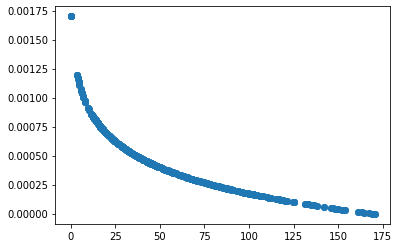

In [92]:
plt.scatter(d, F[0, 10, :])

## 1. Forecasting

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(0,500), out[0][1, :], c='b', label='Real Values')
plt.plot(range(0, 500), out[1][1, :], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper left')
plt.title('Non-Stationary Simulation')
plt.grid()
plt.show()

In [ ]:
plot_forecast(out[0], out[1], 6, 5, 300, 500, (16,7))

## 2. Shape function

In [94]:
F_hats = []
for i in range(5):
    out = load_pickle(f'output/non_stationary/{shape}/out{i}.pickle')
    f = out[2].transpose()
    F_hats.append(f)
F_hats = np.stack(F_hats)

In [95]:
idx = range(0, 300, 10)
F_agg = F[:, idx, :].mean(0)
F_hat_agg = F_hats[:, idx, :].mean(0)
F_agg.shape, F_hat_agg.shape

((30, 900), (30, 900))

In [54]:
# out = load_pickle('output/test.pickle')
# idx = range(0, 300, 10)
# F_hat_agg =  out[2].transpose()[idx, ]
# F_agg = F[:, idx, :].mean(0)
# F_agg.shape, F_hat_agg.shape

((30, 900), (30, 900))

In [96]:
F_agg[0, :30], F_hat_agg[0, :30] 

(array([0.00180734, 0.00052049, 0.00056082, 0.00052938, 0.00096349,
        0.0002523 , 0.00041266, 0.00046845, 0.000683  , 0.00084144,
        0.0001454 , 0.00042362, 0.00124096, 0.00052837, 0.00031728,
        0.00039629, 0.00046274, 0.00044502, 0.00044857, 0.00054626,
        0.00043657, 0.00037319, 0.00102461, 0.00012733, 0.00050572,
        0.00051249, 0.00041692, 0.00120921, 0.00019738, 0.00039617]),
 array([0.02264331, 0.01560889, 0.01640933, 0.01579622, 0.02137771,
        0.00592841, 0.01238293, 0.01417358, 0.01828891, 0.02022927,
        0.00187753, 0.01286345, 0.02216752, 0.01576176, 0.00868196,
        0.0119039 , 0.01391191, 0.01333593, 0.01338437, 0.01607229,
        0.01311283, 0.01059429, 0.02146836, 0.00161433, 0.01521605,
        0.01537585, 0.01268663, 0.02202095, 0.00352118, 0.01185576],
       dtype=float32))

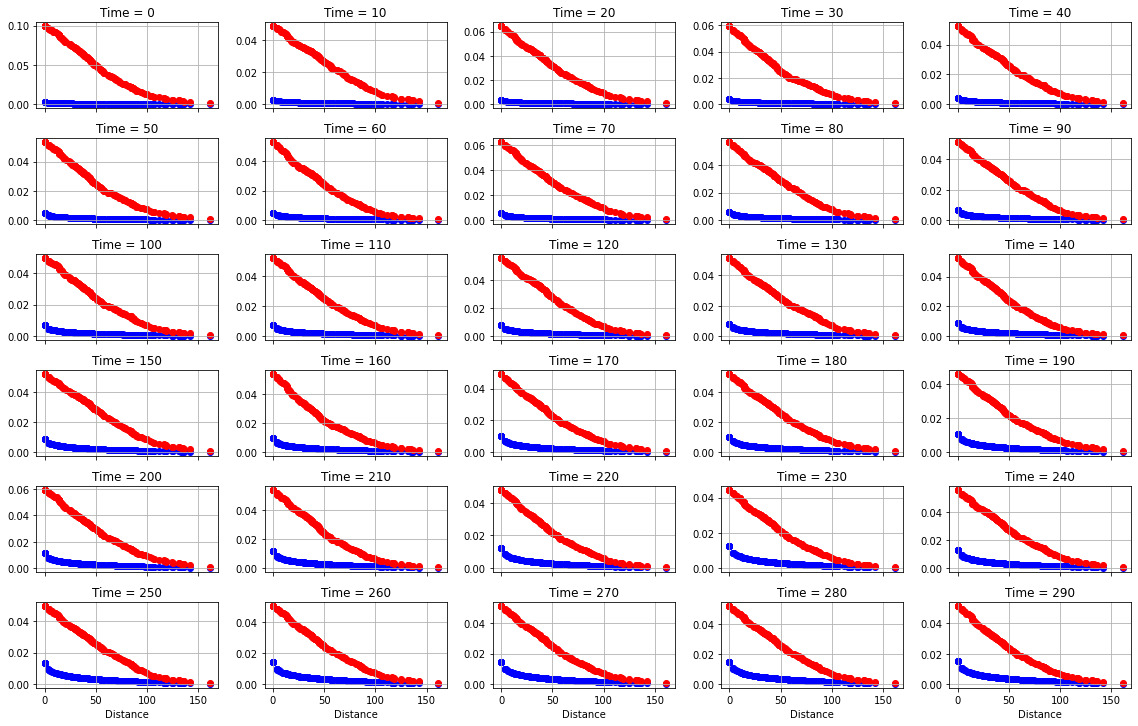

In [87]:
plot_sf(d, F_agg, F_hat_agg, 6, 5, 200, (16, 10))

## 3. Multi-Step

In [ ]:
h1 = load_pickle('output/nst_sim_h1.pickle')
h2 = load_pickle('output/nst_sim_h10.pickle')


In [ ]:
ts = 500
fig, axs = plt.subplots(1, 2, figsize=(18,8))
axs[0].plot(h1[0][10, -ts:], c='b')
axs[0].plot(h1[1][10, -ts:], c='r')
axs[0].title.set_text('h = 1')

axs[1].plot(h2[0][10, -ts:], c='b')
axs[1].plot(h2[1][10, -ts:], c='r')
axs[1].title.set_text('h = 5')
plt.show()

# Baselines

In [ ]:
dataset = 'nst_sim'
horizon = 1
loc, n = 30, 500

In [ ]:
#  Scale data and horizon
# data = scale(data, 0.3, 0)

In [ ]:
x_offsets = np.sort(np.concatenate((np.arange(1-horizon, 1, 1),)))
y_offsets = np.sort(np.arange(1, 1+horizon, 1))
x_ids, y_ids = [], []
min_t = abs(min(x_offsets))
max_t = abs(n - abs(max(y_offsets)))  # Exclusive
for t in range(min_t, max_t):
    x_ids.extend(t + x_offsets)
    y_ids.extend(t + y_offsets)

In [ ]:
def aggregate(v, n=7320, h=20, loc=30):
    out = [np.zeros((1, loc)) for _ in range(n)]
    cnt = [np.ones((1, loc)) for _ in range(h)] + [np.zeros((1, loc)) for _ in range(n-h)]
    L = len(y_ids)
    for l in range(L):
        i = y_ids[l] 
        out[i] += v[l, :]
        cnt[i] += 1

    outs = np.concatenate(out)
    cnts = np.concatenate(cnt)
    return (outs/cnts).transpose()

In [ ]:
def load_outputs(path, n, h, loc):
    data = np.load(path)
    input, pred, label = data['input'], data['prediction'], data['truth']
    
    
    if 'DC-RNN' in path:
        pred, label = pred.swapaxes(0,1), label.swapaxes(0,1)
        
    predictions = aggregate(pred.reshape(-1, loc), n, h, loc)
    labels = aggregate(label.reshape(-1, loc), n, h, loc)
#     print(input.shape, pred.shape, label.shape, '//', predictions.shape, labels.shape)
    
    return predictions, labels

## Visualization

In [ ]:
def compute_metrics(name, p, l, horizon, size = None):
    if size:
        p = p[:, -size:]
        l = l[:, -size:]
    # Mean absolute error
    mae = (np.abs(p - l) / horizon).mean()

    # Mean Absolute Percentage Error
    smape = 2.0 * (np.abs(l-p)/(np.abs(l+1e-10)+np.abs(p+1e-10))).mean()

    # Root Mean Squared Error
    rmse = ((p - l)**2 / horizon).mean(-1)
    rmse = np.sqrt(rmse).mean()


    return mae, smape, rmse

In [ ]:
def get_result(i, horizon, collector):
    
    for name in names:
        p, l = load_outputs(f'{name}/data/{dataset}/output/preds{i}.npz', n, horizon, loc)
        out = compute_metrics(name, p, l, horizon)
        collector[name]['mae'].append(out[0])
        collector[name]['smape'].append(out[1])
        collector[name]['rmse'].append(out[2])
    return collector

In [ ]:
names = ['DC-RNN', 'FC-GAGA', 'GMAN', 'ConvLSTM']
collector = {}
for name in names:
    collector[name] = {"mae": [], "smape": [], "rmse": []}

In [ ]:
for i in tqdm(range(100)):
    collector = get_result(i, horizon, collector)    

In [ ]:
for name in names:
    means, stds = [], []
    for metric in ['mae', 'smape', 'rmse']:
        m = np.array(collector[name][metric]).mean()
        s = stats.sem(collector[name][metric])
        means.append(m)
        stds.append(s)
    print(f"{name} & {means[0]:.3f}\pm{stds[0]:.3f} & {means[1]:.3f}\pm{stds[1]:.3f} & {means[2]:.3f}\pm{stds[2]:.3f} \\\\")

In [ ]:
dataset = 'st_sim' if dataset == 'sim' else dataset
mae, smape, rmse = [], [], []
iter = range(100)
for i in tqdm(iter):
    p = np.load(f'output/{dataset}/preds{i}.npy')
    l = pd.read_csv(f'data/{dataset}/csv/s{i}.csv')
    l = l.iloc[:, 1:].to_numpy()
    a, b, c = compute_metrics('Shape function', p, l , horizon)
    mae.append(a)
    smape.append(b)
    rmse.append(c)

A = np.array(mae).mean(), stats.sem(mae)
B = np.array(smape).mean(), stats.sem(smape)
C = np.array(rmse).mean(), stats.sem(rmse)
print(f"Shape function & {A[0]:.3f}\pm{A[1]:.3f} & {B[0]:.3f}\pm{B[1]:.3f} & {C[0]:.3f}\pm{C[1]:.3f} \\\\")

## Mine /Air

In [5]:
ids, d = load_pickle('data/air/sample.pickle')

In [6]:
out = load_pickle('output/air.pickle')

In [7]:
out[0].shape, out[1].shape, out[2].shape

((33, 400), (33, 400), (1089, 300))

In [ ]:
n = 10
plt.figure(figsize=(10,5))
plt.plot(out[0][n, 300:], c='b', label='Real Values')
plt.plot(out[1][n, 300:], c='r', label='Forecasts')
plt.xlabel('Time')
plt.legend(fontsize='medium', loc='upper right')
plt.title('Stationary Simulation')
plt.grid()
plt.show()

In [ ]:
plot_forecast(out[0], out[1], 6, 5, 300, 400, (16,7))

In [11]:
out[2].shape

(1089, 300)

In [12]:
idx = range(0, 50, 5)
f = out[2].transpose()[idx, ]
f.shape

(10, 1089)

In [ ]:
plot_sf(d, f, f, 5, 2, 150, (16, 10), 100)